In [2]:
##########
##References
##1. https://nbviewer.jupyter.org/github/jckantor/ND-Pyomo-Cookbook/blob/master/notebooks/02.01-Production-Models-with-Linear-Constraints.ipynb
##2. https://jckantor.github.io/ND-Pyomo-Cookbook/
##3. PYOMO FUNDAMENTALS 1: https://www.osti.gov/servlets/purl/1376827
##4. PYOMO FUNDAMENTALS 2: 
##########
import pyomo.environ as pyo
from pyomo.opt import SolverFactory
import pandas as pd

    maximize  40*x + 30*y
    s.t. x <= 40
         x + y <= 80
         2*x + y <= 100
         x, y >= 0

In [3]:
model = pyo.ConcreteModel()

# for access to dual solution for constraints
model.dual = pyo.Suffix(direction=pyo.Suffix.IMPORT)

# declare decision variables
model.x = pyo.Var(domain=pyo.NonNegativeReals)
model.y = pyo.Var(domain=pyo.NonNegativeReals)

# declare objective
model.profit = pyo.Objective(
    expr = 40*model.x + 30*model.y,
    sense = pyo.maximize)

# declare constraints
model.demand = pyo.Constraint(expr = model.x <= 40)
model.laborA = pyo.Constraint(expr = model.x + model.y <= 80)
model.laborB = pyo.Constraint(expr = 2*model.x + model.y <= 100)

opt = SolverFactory('cplex')
results = opt.solve(model) 

In [20]:
print('*********MODEL DISPLAY*************')
model.display()
print('*********MODEL PPRINT**************')
model.pprint()
print('*********MODEL RESULTS*************')
print(results.write())

*********MODEL DISPLAY*************
Model unknown

  Variables:
    x : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :  20.0 :  None : False : False : NonNegativeReals
    y : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :  60.0 :  None : False : False : NonNegativeReals

  Objectives:
    profit : Size=1, Index=None, Active=True
        Key  : Active : Value
        None :   True : 2600.0

  Constraints:
    demand : Size=1
        Key  : Lower : Body : Upper
        None :  None : 20.0 :  40.0
    laborA : Size=1
        Key  : Lower : Body : Upper
        None :  None : 80.0 :  80.0
    laborB : Size=1
        Key  : Lower : Body  : Upper
        None :  None : 100.0 : 100.0
*********MODEL PPRINT**************
2 Var Declarations
    x : Size=1, Index=None
        Key  : Lower : Value : Upper : Fixed : Stale : Domain
        None :     0 :  20.0 :  None : False : False : 

In [21]:
print('*********DECISION VARIABLES**********')
constraint_cols = ['Lower Bound','value','Upper Bound']
constraint_data = tuple()
(x_lb,x_ub) = model.x.bounds
(y_lb,y_ub) = model.y.bounds
constraint_data = (
    (x_lb,model.x(),x_ub),
    (y_lb,model.y(),y_ub)
)
df = pd.DataFrame(constraint_data,columns=constraint_cols)
df

*********DECISION VARIABLES**********


,Lower Bound,value,Upper Bound
0,0,20.0,None
1,0,60.0,None


In [22]:
print('*********INCREMENTAL COST**********')
constraint_cols = ['Constraint','value','lslack','uslack','dual']
constraint_data = tuple()
for c in (model.demand, model.laborA, model.laborB):
    #print(f'{c}, {c()}, {c.lslack()}, {c.uslack()}, {model.dual[c]}')
    constraint_data += ((f'{c}', c(), c.lslack(), c.uslack(), model.dual[c]),)
import pandas as pd
df = pd.DataFrame(constraint_data,columns=constraint_cols)
df

*********INCREMENTAL COST**********


,Constraint,value,lslack,uslack,dual
0,demand,20.0,inf,20.0,-0.0
1,laborA,80.0,inf,0.0,20.0
2,laborB,100.0,inf,0.0,10.0


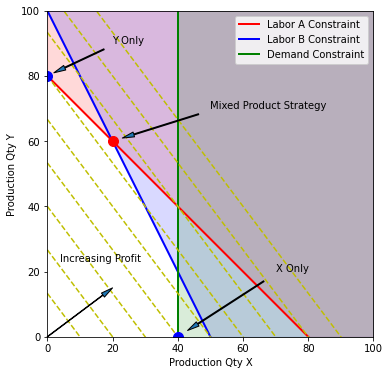

In [20]:
%matplotlib inline
from matplotlib.pylab import *
import os
figure(figsize=(6,6))
subplot(111, aspect='equal')
axis([0,100,0,100])
xlabel('Production Qty X')
ylabel('Production Qty Y')

# Labor A constraint
x = array([0,80])
y = 80 - x
plot(x,y,'r',lw=2)
fill_between([0,80,100],[80,0,0],[100,100,100],color='r',alpha=0.15)

# Labor B constraint
x = array([0,50])
y = 100 - 2*x
plot(x,y,'b',lw=2)
fill_between([0,50,100],[100,0,0],[100,100,100],color='b',alpha=0.15)

# Demand constraint
plot([40,40],[0,100],'g',lw=2)
fill_between([40,100],[0,0],[100,100],color='g',alpha=0.15)

legend(['Labor A Constraint','Labor B Constraint','Demand Constraint'])

# Contours of constant profit
x = array([0,100])
for p in linspace(0,3600,10):
    y = (p - 40*x)/30
    plot(x,y,'y--')

# Optimum
plot(20,60,'r.',ms=20)
annotate('Mixed Product Strategy', xy=(20,60), xytext=(50,70),
         arrowprops=dict(shrink=.1,width=1,headwidth=5))

plot(0,80,'b.',ms=20)
annotate('Y Only', xy=(0,80), xytext=(20,90),
         arrowprops=dict(shrink=0.1,width=1,headwidth=5))

plot(40,0,'b.',ms=20)
annotate('X Only', xy=(40,0), xytext=(70,20),
         arrowprops=dict(shrink=0.1,width=1,headwidth=5))

text(4,23,'Increasing Profit')
annotate('', xy=(20,15), xytext=(0,0),
         arrowprops=dict(width=0.5,headwidth=5))

fname = 'LPprog01.png'
fname = os.path.join('figures', fname) if os.path.exists('figures') else fname
savefig(fname, bbox_inches='tight')

In [9]:
[i for i in dir(model.x.lb())]

TypeError: 'int' object is not callable

In [18]:
model.x.bounds

(0, None)